In [4]:
# Imports // Sets up the tools and loads the file.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor # Gradient Descent Linear Regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Load Data
# Ensure your file is named 'fuel_data.csv'
df = pd.read_csv('fuel_data.csv')

# View the first few rows to check column names
print("Original Data Head:")
print(df.head())

# Check data types
print("\nData Info:")
print(df.info())


Original Data Head:
    Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   


In [5]:
# 1. Select only the columns we need for regression
# Based on your dataset description, we need Engine Size, Cylinders, Fuel Consumption, and CO2
# We use .copy() to avoid SettingWithCopyWarning
clean_df = df[['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)', 'CO2 Emissions(g/km)']].copy()

# 2. Rename columns to be simple (Removes spaces and units)
clean_df.columns = ['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION', 'CO2EMISSIONS']

# 3. Check for missing values (Rubric requirement)
print("\nMissing Values before drop:")
print(clean_df.isnull().sum())

# Drop rows with missing values
clean_df.dropna(inplace=True)

print("\nCleaned Data Head:")
print(clean_df.head())


Missing Values before drop:
ENGINESIZE         0
CYLINDERS          0
FUELCONSUMPTION    0
CO2EMISSIONS       0
dtype: int64

Cleaned Data Head:
   ENGINESIZE  CYLINDERS  FUELCONSUMPTION  CO2EMISSIONS
0         2.0          4              8.5           196
1         2.4          4              9.6           221
2         1.5          4              5.9           136
3         3.5          6             11.1           255
4         3.5          6             10.6           244


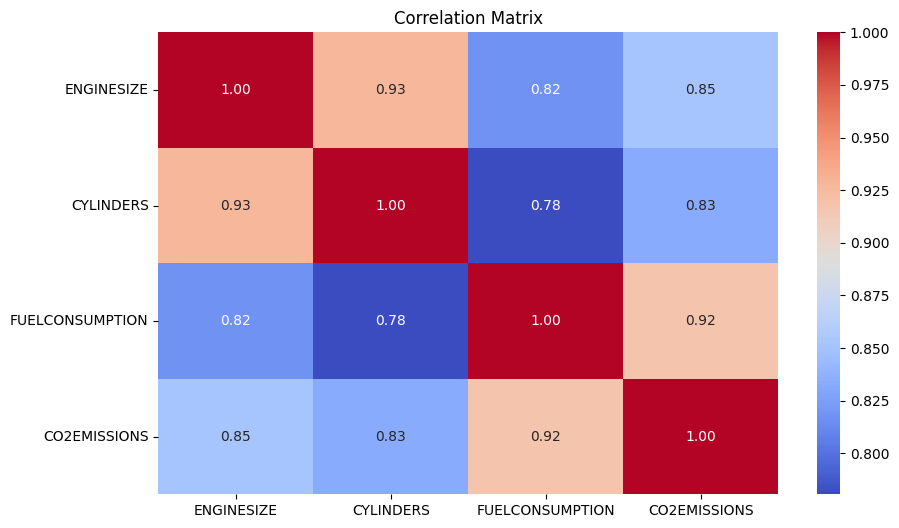

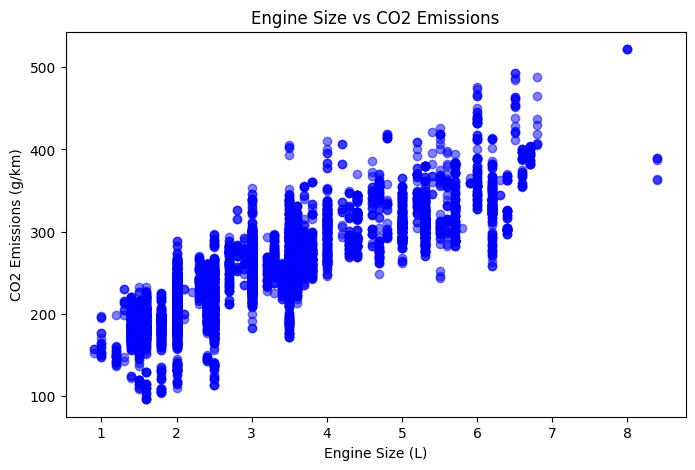

In [6]:
# Visualization 1: Correlation Heatmap
# This shows how strongly features are related to CO2
plt.figure(figsize=(10, 6))
sns.heatmap(clean_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



# Visualization 2: Scatter Plot
# Shows the relationship between Engine Size and CO2
plt.figure(figsize=(8, 5))
plt.scatter(clean_df.ENGINESIZE, clean_df.CO2EMISSIONS, color='blue', alpha=0.5)
plt.xlabel("Engine Size (L)")
plt.ylabel("CO2 Emissions (g/km)")
plt.title("Engine Size vs CO2 Emissions")
plt.show()

In [7]:
# Define Features (X) and Target (y)
X = clean_df[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION']]
y = clean_df['CO2EMISSIONS']

# Split into Train (80%) and Test (20%) sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print("Data standardized and split.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Data standardized and split.
Training samples: 5908
Testing samples: 1477


In [8]:
# 1. Linear Regression using SGD (Stochastic Gradient Descent)
# We use SGDRegressor because standard LinearRegression() uses OLS, not Gradient Descent.
lr_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)

# 2. Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_pred)

# 3. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)

# Output Results
print(f"Linear Regression MSE: {lr_mse:.2f}")
print(f"Decision Tree MSE:     {dt_mse:.2f}")
print(f"Random Forest MSE:     {rf_mse:.2f}")

Linear Regression MSE: 423.46
Decision Tree MSE:     140.33
Random Forest MSE:     104.57


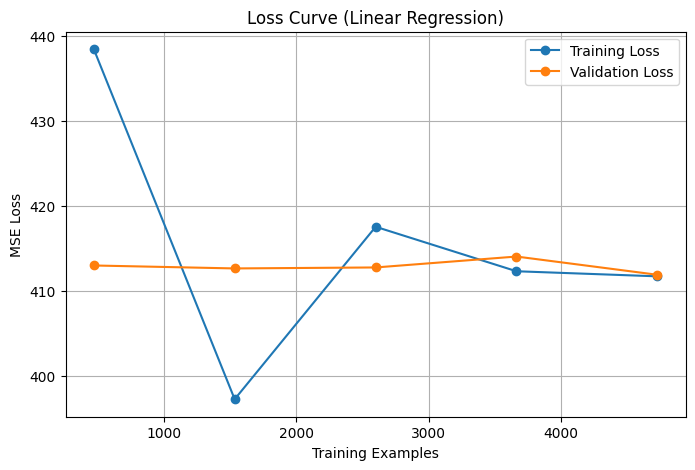

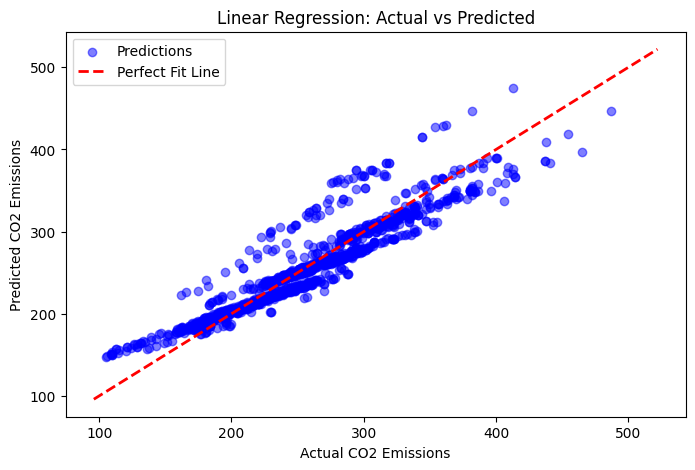

In [9]:
# Plot Learning Curve (Loss) for the Linear Model
train_sizes, train_scores, test_scores = learning_curve(
    lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Convert negative MSE to positive
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Loss")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation Loss")
plt.xlabel("Training Examples")
plt.ylabel("MSE Loss")
plt.title("Loss Curve (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()


# (Image of Learning Curve Graph)


# Plot Scatter of Predictions vs Actual (Linear Line)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, lr_pred, alpha=0.5, color='blue', label='Predictions')
# Plot the perfect fit line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Fit Line')
plt.xlabel("Actual CO2 Emissions")
plt.ylabel("Predicted CO2 Emissions")
plt.title("Linear Regression: Actual vs Predicted")
plt.legend()
plt.show()

In [10]:
# Identify Best Model
models = {
    "Linear Regression": lr_mse,
    "Decision Tree": dt_mse,
    "Random Forest": rf_mse
}

best_model_name = min(models, key=models.get)
print(f"The best performing model is: {best_model_name}")

# Select the model object
if best_model_name == "Random Forest":
    final_model = rf_model
elif best_model_name == "Decision Tree":
    final_model = dt_model
else:
    final_model = lr_model

# Save Model and Scaler to files
joblib.dump(final_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("SUCCESS: 'best_model.pkl' and 'scaler.pkl' have been saved.")

The best performing model is: Random Forest
SUCCESS: 'best_model.pkl' and 'scaler.pkl' have been saved.


In [11]:
import os
print(os.getcwd())
print(os.listdir())

c:\Users\USER\Desktop\multivariate.ipynb
['.venv', '.vscode', 'API', 'best_model.pkl', 'fuel_data.csv', 'mutlivariate.ipynb', 'scaler.pkl']
